In [1]:
import xarray as xr
import numpy as np
import datetime
import pandas as pd
import gsw
from scipy import interpolate

import matplotlib as mpl
import matplotlib.pyplot as plt


Here dictionaries

In [2]:
################################################################################
########    DICTIONARIES
################################################################################

reg_ext = {
    'lab': {
        'lon' : (-60, -30),
        'lat' : (50, 65),
        'name' : 'Labrador and Irminger Seas'
    },
    'gul': {
        'lon' : (-75, -45),
        'lat' : (30, 45),
        'name' : 'Gulf Stream'
    },
    'noe': {
        'lon' : (-30, -5),
        'lat' : (45, 60),
        'name' : 'North East Sea'
    }
}

## Selected points in the regions
### Gulf S: (60W, 35N)
### Lab -I: (50W, 55N)
### Nor E: (17.5W, 52.5N)
points = {
    'gul': {
        'lon': -60., 
        'lat': 35.
    },
    'lab': {
        'lon': -50., 
        'lat': 55.
    },
    'noe': {
        'lon': -17.5, 
        'lat': 52.5}
}


gulf = {
    12 : {
        't': (17.5, 19.), 
        's': (36.45, 36.65),
        'd': (26.3, 26.65)
    },
    25 : {
        't': (17.5, 25.), 
        's': (36.25, 36.75),
        'd': (24., 27.)
    },
    38 : {
        't': (17.5, 26.), 
        's': (36.4, 36.8),
        'd': (24., 26.5)
    },
    51 : {
        't': (18., 22.2), 
        's': (36.4, 36.7),
        'd': (25., 26.5)
    }
}


labrador = {
    12 : {
        't': (2.75, 3.5), 
        's': (34.65, 34.85),
        'd': (27.6, 27.75)
    },
    25 : {
        't': (3., 8.), 
        's': (34.5, 35.),
        'd': (26., 29.)
    },
    38 : {
        't': (3., 11.), 
        's': (34.5, 35.),
        'd': (26., 28.)
    },
    51 : {
        't': (4., 5.5), 
        's': (34.25, 35.),
        'd': (27.2, 27.7)
    }
}


north = {
    12 : {
        't': (10.7, 11.7), 
        's': (35.35, 35.5),
        'd': (26.9, 27.3)
    },
    25 : {
        't': (10., 15.), 
        's': (35.3, 35.7),
        'd': (26.2, 27.2)
    },
    38 : {
        't': (11., 16.), 
        's': (35.3, 35.7),
        'd': (26., 28.)
    },
    51 : {
        't': (11., 13.), 
        's': (35.45, 35.65),
        'd': (26.8, 27.2)
    }
}

Here we have the fucntions

In [3]:
################################################################################
########    FUNCTIONS
################################################################################

## Function to make the (x,y)-> (lon,lat) grid
def Grid(data_set):
    """
        Grid is a function that creates a rectangular grid using as x a longitude
        array and for y a latitude array.
        
        Parameters:
        ------------
            
        data_set : DataArray
            Is the dataset from which we will plot the histogram.
        
        Output:
        -------
        (x, y) : n-arrays
            Arrays that correspond for each (lon,lat) point
    """
    x = data_set.longitude
    y = data_set.latitude
    
    x, y = np.meshgrid(x, y)
    return(x, y)



## Function to crop the dataset
def Crops(coord, d_set):
    """
        Crops is a function that takes a data set and crops it into smaller
        region, using as parameters the values given by the dictionary 
        reg_ext.
        
        Parameters:
        ------------
            
        coord : string
            Key value that identifies the region to obtain
        
        d_set : DataArray
            Dataset to be cropped
        
        Output:
        -------
        new_ds : DataArray
            New data array corresponding to the region stated by 'coord'
    """
    
    lon1, lon2 = reg_ext[coord]['lon']
    lat1, lat2 = reg_ext[coord]['lat']
    name_fig = reg_ext[coord]['name']
    
    new_ds = d_set.sel(longitude=slice(lon1, lon2), latitude=slice(lat1, lat2))
    return(new_ds)


def Limits(dictionary, t):
    a = dictionary[t]['t']
    b = dictionary[t]['s']
    c = dictionary[t]['d']
    
    return(a, b, c)


def Convert(data_set, t):
    dep = - data_set.depth
    sal = data_set.so[t].values
    tem = data_set.to[t].values
    lon = float(data_set.longitude.values)
    lat = float(data_set.latitude.values)
    
    # Pressure -> depth latitudde
    pr = gsw.p_from_z(dep, lat)
    sa = gsw.conversions.SA_from_SP(sal, pr, lon, lat)
    ct = gsw.conversions.CT_from_t(sa, tem, pr)
    ds = gsw.density.sigma0(sa, ct)

    return(dep, sa, ct, ds, pr)


def New_density(tem_10, sal_10, pss_10):
    pot_10 = gsw.pt0_from_t(sal_10, tem_10, pss_10)
    dpt = pot_10 - 0.2

    tem_02 = gsw.conversions.CT_from_pt(sal_10, dpt)
    ds_02 = gsw.density.sigma0(sal_10, tem_02)

    return (ds_02, tem_02)


def Point(data_set, coord):
    point = data_set.sel(longitude=points[coord]['lon'], 
           latitude=points[coord]['lat'], method='nearest')
    return(point)


#Function to calculate MLD, according to a threshold value
def ML_depth(depth, density, delta):

    for i in range(2, len(density)):
        diff = density[i] - density[1]
#        print(diff)

        if (diff >= delta):
            return(float(depth[i]), i)
            break

            

def Densities_delta(den, tem, sal, pss, t):
    # Calculating the density at dT = 0.2 degrees
    # pot temp_10, sal_10m -> New density at dT = 0.2
    den10 = den[1]
    tem10 = tem[1]
    sal10 = sal[1]
    pre10 = pre[1]

    den02, tem02 = New_density(tem10, sal10, pre10)
    dDv = den02 - den10
    
    return(den02, dDv)

In [15]:
################ PLOTS
## dep, tem, sal, ds_g

def Plot_density(dep, tem, sal, den, place, t, name=None, complete=False):
    # Temperature
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6, 9))
    color = 'orange'
    ax[0].set_xlabel('Temperature ($^o$C)', color=color)
    ax[0].set_ylabel('Depth (m)')
    ax[0].plot(tem, dep, color=color)
    ax[0].tick_params(axis='x', labelcolor=color)
    ax[0].set_ylim(-4500., 0.)

    # Salinity
    ax2 = ax[0].twiny()
    color = 'blue'
    ax2.set_xlabel('Salinity (PSU)', color=color)
    ax2.plot(sal, dep, color=color)
    ax2.tick_params(axis='x', labelcolor=color)
#    ax2.set_xlim(34.5, 37.)

    # Density
    ax3 = ax[0].twiny()
    color = 'green'
    ax3.set_xlabel('Density (kg m$^{-3}$)', color=color)
    ax3.plot(den, dep, color=color)
    ax3.spines["top"].set_position(("axes", 1.10))
    ax3.tick_params(axis='x', labelcolor=color)
#    ax3.set_xlim(25., 28.)

#############
    ###Second plot, zoomed
    lims_t, lims_s, lims_d = Limits(place, t)
    # Temperature
    color = 'orange'
    ax[1].set_xlabel('Temperature ($^o$C)', color=color)
    #ax[1].set_ylabel('Depth (m)')
    ax[1].plot(tem, dep, color=color)
    ax[1].tick_params(axis='x', labelcolor=color)
    ax[1].set_xlim(lims_t)
    
    xmin = lims_t[0]
    xmax = lims_t[1]
    
    ax[1].hlines(-MLD_a, xmin, xmax, colors='k', 
                linestyles='solid', linewidths=3)

    ax[1].hlines(MLD_f, xmin, xmax, colors='m', 
                linestyles='solid', linewidths=3)

    ax[1].hlines(MLD_v, xmin, xmax, colors='c', 
                linestyles='solid', linewidths=1)
    
    ax[1].hlines(MLD_int, xmin, xmax, colors='r', 
                linestyles='dashdot', linewidths=2)

    # Salinity
    ax2 = ax[1].twiny()
    color = 'blue'
    ax2.set_xlabel('Salinity (PSU)', color=color)  
    ax2.plot(sal, dep, color=color)
    ax2.tick_params(axis='x', labelcolor=color)
    ax2.set_xlim(lims_s)

    # Density
    ax3 = ax[1].twiny()
    color = 'green'
    ax3.set_xlabel('Density (kg m$^{-3}$)', color=color)
    ax3.plot(den, dep, color=color)
    ax3.spines["top"].set_position(("axes", 1.10))
    ax3.tick_params(axis='x', labelcolor=color)
    ax3.set_xlim(lims_d)

    plt.ylim(-300., 0)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped

    if not name:
        plt.show()
    else:
        plt.savefig(name)

In [18]:
###############################################################################
###########         MAIN PROGRAM
###############################################################################

dir_1 = '../../../data_ARMOR/'
dir_2 = '../../Vertical-prof/'
fl_n1 = 'ARMOR_2005.nc'

c_armor = xr.open_dataset(dir_1 + fl_n1)

## Selected points in the regions
### Gulf S: (60W, 35N)
### Lab -I: (50W, 55N)
### Nor E: (17.5W, 52.5N)

gl = Crops('gul', c_armor)
lb = Crops('lab', c_armor)
nr = Crops('noe', c_armor)

## Gulf Stream

Spring time, March 30

MDL by ARMOR:  97.40
MDL fixed: -100.00
MDL by variable: -125.00
MDL by variable+interpolation: -114.82


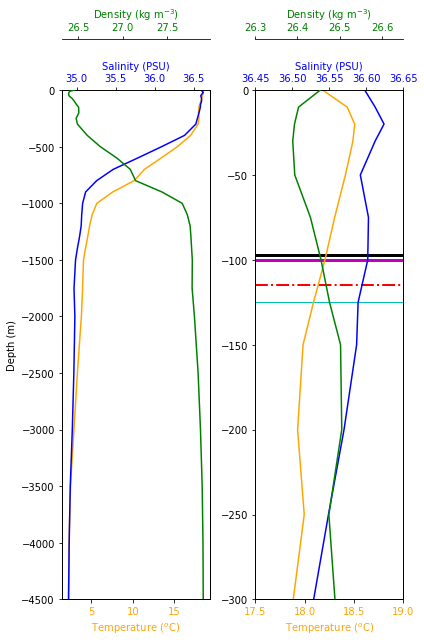

In [19]:
# Time step we work on:: 12, 25, 38, 51
p_gl = Point(gl, 'gul')
place = gulf
t = 12

# Convert(data_set, t) -> (dep, sal, tem, den, temp_pot)
dep, sal, tem, den, pre = Convert(p_gl, t)

## Calculating the deltas
dn02_gl, Ddv_gl = Densities_delta(den, tem, sal, pre, t)
Ddf_gl = 0.03

MLD_a = p_gl.mlotst[t].values
MLD_f, jf = ML_depth(dep, den, Ddf_gl)
MLD_v, jv = ML_depth(dep, den, Ddv_gl)

# Calculating depth from density :: Interpolation
x = den[jv-1:jv+2]
y = dep[jv-1:jv+2]
dep_dens = interpolate.interp1d(x, y, kind='linear')

MLD_int = dep_dens(dn02_gl)
print("MDL by ARMOR: % 5.2f" %(MLD_a))
print("MDL fixed: % 5.2f" %(MLD_f))
print("MDL by variable: % 5.2f" %(MLD_v))
print("MDL by variable+interpolation: % 5.2f" %(MLD_int))

## Making plot
name_fig = dir_2 + 'Gulf-'+ str(t)+'.png'
Plot_density(dep, p_gl.to[t], p_gl.so[t], den, place=place, t=12, name=name_fig)


Summer time, June 29

25
MDL by ARMOR:  11.60
MDL fixed: -20.00
MDL by variable: -20.00
MDL by variable+interpolation: -11.99


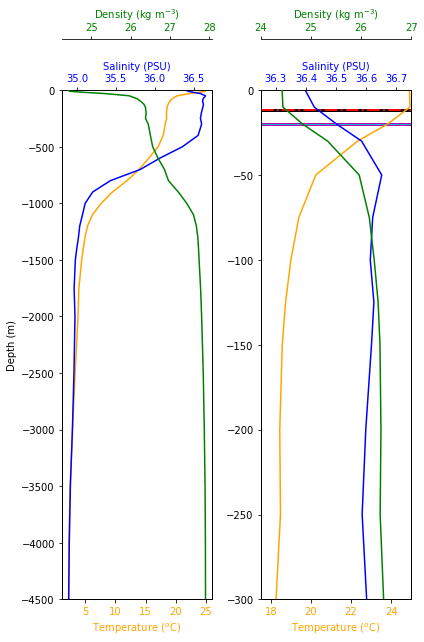

In [88]:
# Time step we work on:: 12, 25, 38, 51
p_gl = Point(gl, 'gul')
place = gulf
t = 25
print(t)

# Convert(data_set, t) -> (dep, sal, tem, den, temp_pot)
dep, sal, tem, den, pre = Convert(p_gl, t)

## Calculating the deltas
dn02_gl, Ddv_gl = Densities_delta(den, tem, sal, pre, t)
Ddf_gl = 0.03

MLD_a = p_gl.mlotst[t].values
MLD_f, jf = ML_depth(dep, den, Ddf_gl)
MLD_v, jv = ML_depth(dep, den, Ddv_gl)

# Calculating depth from density :: Interpolation
x = den[jv-1:jv+2]
y = dep[jv-1:jv+2]
dep_dens = interpolate.interp1d(x, y, kind='linear')


MLD_int = dep_dens(dn02_gl)
print("MDL by ARMOR: % 5.2f" %(MLD_a))
print("MDL fixed: % 5.2f" %(MLD_f))
print("MDL by variable: % 5.2f" %(MLD_v))
print("MDL by variable+interpolation: % 5.2f" %(MLD_int))

## Making plot
name_fig = dir_2 + 'Gulf-'+ str(t)+'.png'
Plot_density(dep, p_gl.to[t], p_gl.so[t], den, place, t, name_fig)


Autumn time, September 28

38
MDL by ARMOR:  35.20
MDL fixed: -50.00
MDL by variable: -50.00
MDL by variable+interpolation: -35.87


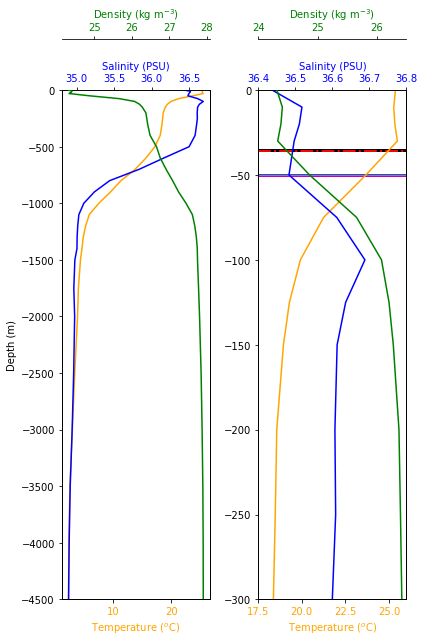

In [89]:
# Time step we work on:: 12, 25, 38, 51
p_gl = Point(gl, 'gul')
place = gulf
t = 38
print(t)

# Convert(data_set, t) -> (dep, sal, tem, den, temp_pot)
dep, sal, tem, den, pre = Convert(p_gl, t)

## Calculating the deltas
dn02_gl, Ddv_gl = Densities_delta(den, tem, sal, pre, t)
Ddf_gl = 0.03

MLD_a = p_gl.mlotst[t].values
MLD_f, jf = ML_depth(dep, den, Ddf_gl)
MLD_v, jv = ML_depth(dep, den, Ddv_gl)

# Calculating depth from density :: Interpolation
x = den[jv-1:jv+2]
y = dep[jv-1:jv+2]
dep_dens = interpolate.interp1d(x, y, kind='linear')


MLD_int = dep_dens(dn02_gl)
print("MDL by ARMOR: % 5.2f" %(MLD_a))
print("MDL fixed: % 5.2f" %(MLD_f))
print("MDL by variable: % 5.2f" %(MLD_v))
print("MDL by variable+interpolation: % 5.2f" %(MLD_int))

## Making plot
name_fig = dir_2 + 'Gulf-'+ str(t)+'.png'
Plot_density(dep, p_gl.to[t], p_gl.so[t], den, place, t, name_fig)


Winter time, December 28

51
MDL by ARMOR:  120.80
MDL fixed: -125.00
MDL by variable: -125.00
MDL by variable+interpolation: -121.80


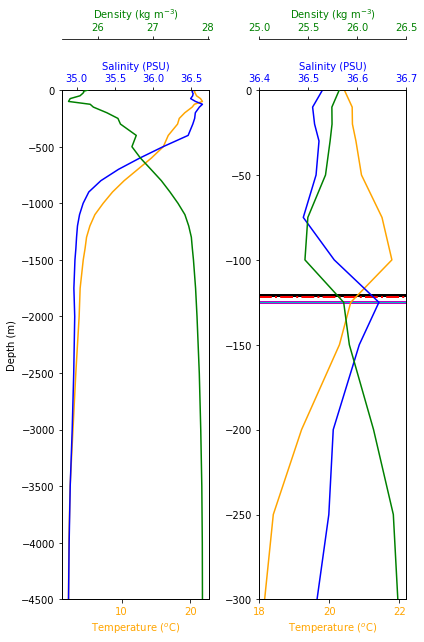

In [90]:
# Time step we work on:: 12, 25, 38, 51
p_gl = Point(gl, 'gul')
place = gulf
t = 51
print(t)

# Convert(data_set, t) -> (dep, sal, tem, den, temp_pot)
dep, sal, tem, den, pre = Convert(p_gl, t)

## Calculating the deltas
dn02_gl, Ddv_gl = Densities_delta(den, tem, sal, pre, t)
Ddf_gl = 0.03

MLD_a = p_gl.mlotst[t].values
MLD_f, jf = ML_depth(dep, den, Ddf_gl)
MLD_v, jv = ML_depth(dep, den, Ddv_gl)

# Calculating depth from density :: Interpolation
x = den[jv-1:jv+2]
y = dep[jv-1:jv+2]
dep_dens = interpolate.interp1d(x, y, kind='linear')


MLD_int = dep_dens(dn02_gl)
print("MDL by ARMOR: % 5.2f" %(MLD_a))
print("MDL fixed: % 5.2f" %(MLD_f))
print("MDL by variable: % 5.2f" %(MLD_v))
print("MDL by variable+interpolation: % 5.2f" %(MLD_int))

## Making plot
name_fig = dir_2 + 'Gulf-'+ str(t)+'.png'
Plot_density(dep, p_gl.to[t], p_gl.so[t], den, place, t, name_fig)


## North East

MDL by ARMOR:  102.50
MDL fixed: -100.00
MDL by variable: -125.00
MDL by variable+interpolation: -108.75


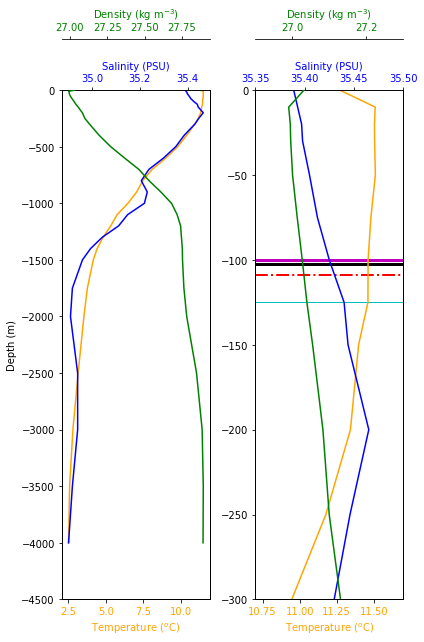

In [91]:
# Time step we work on:: 12, 25, 38, 51
p_gl = Point(nr, 'noe')
place = north
t = 12

# Convert(data_set, t) -> (dep, sal, tem, den, temp_pot)
dep, sal, tem, den, pre = Convert(p_gl, t)

## Calculating the deltas
dn02_gl, Ddv_gl = Densities_delta(den, tem, sal, pre, t)
Ddf_gl = 0.03

MLD_a = p_gl.mlotst[t].values
MLD_f, jf = ML_depth(dep, den, Ddf_gl)
MLD_v, jv = ML_depth(dep, den, Ddv_gl)

# Calculating depth from density :: Interpolation
x = den[jv-1:jv+2]
y = dep[jv-1:jv+2]
dep_dens = interpolate.interp1d(x, y, kind='linear')


MLD_int = dep_dens(dn02_gl)
print("MDL by ARMOR: % 5.2f" %(MLD_a))
print("MDL fixed: % 5.2f" %(MLD_f))
print("MDL by variable: % 5.2f" %(MLD_v))
print("MDL by variable+interpolation: % 5.2f" %(MLD_int))

## Making plot
name_fig = dir_2 + 'North-'+ str(t)+'.png'
Plot_density(dep, p_gl.to[t], p_gl.so[t], den, place, t, name_fig)


25
MDL by ARMOR:  33.10
MDL fixed: -50.00
MDL by variable: -50.00
MDL by variable+interpolation: -33.47


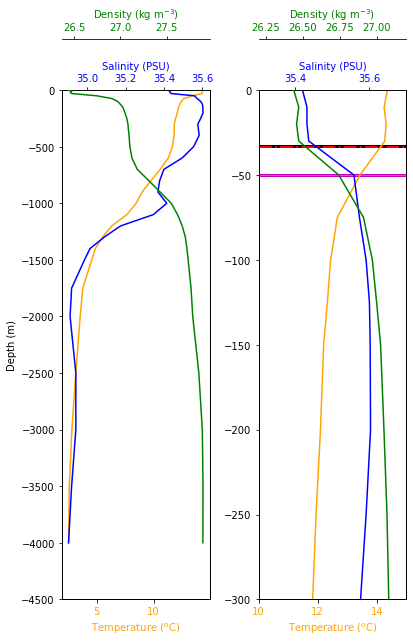

In [92]:
# Time step we work on:: 12, 25, 38, 51
p_gl = Point(nr, 'noe')
place = north
t = 25
print(t)

# Convert(data_set, t) -> (dep, sal, tem, den, temp_pot)
dep, sal, tem, den, pre = Convert(p_gl, t)

## Calculating the deltas
dn02_gl, Ddv_gl = Densities_delta(den, tem, sal, pre, t)
Ddf_gl = 0.03

MLD_a = p_gl.mlotst[t].values
MLD_f, jf = ML_depth(dep, den, Ddf_gl)
MLD_v, jv = ML_depth(dep, den, Ddv_gl)

# Calculating depth from density :: Interpolation
x = den[jv-1:jv+2]
y = dep[jv-1:jv+2]
dep_dens = interpolate.interp1d(x, y, kind='linear')


MLD_int = dep_dens(dn02_gl)
print("MDL by ARMOR: % 5.2f" %(MLD_a))
print("MDL fixed: % 5.2f" %(MLD_f))
print("MDL by variable: % 5.2f" %(MLD_v))
print("MDL by variable+interpolation: % 5.2f" %(MLD_int))

## Making plot
name_fig = dir_2 + 'North-'+ str(t)+'.png'
Plot_density(dep, p_gl.to[t], p_gl.so[t], den, place, t, name_fig)


38
MDL by ARMOR:  33.20
MDL fixed: -50.00
MDL by variable: -50.00
MDL by variable+interpolation: -33.55


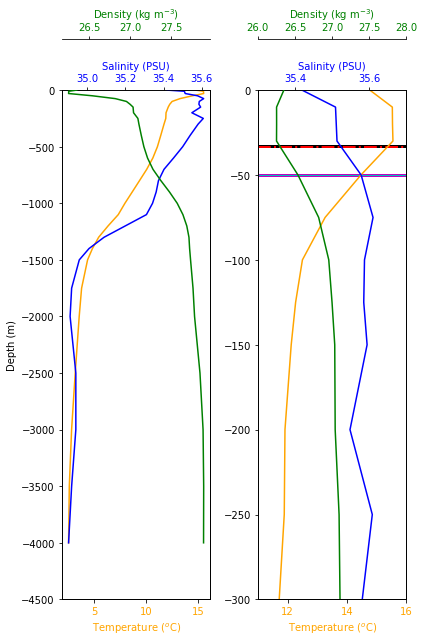

In [93]:
# Time step we work on:: 12, 25, 38, 51
p_gl = Point(nr, 'noe')
place = north
t = 38
print(t)

# Convert(data_set, t) -> (dep, sal, tem, den, temp_pot)
dep, sal, tem, den, pre = Convert(p_gl, t)

## Calculating the deltas
dn02_gl, Ddv_gl = Densities_delta(den, tem, sal, pre, t)
Ddf_gl = 0.03

MLD_a = p_gl.mlotst[t].values
MLD_f, jf = ML_depth(dep, den, Ddf_gl)
MLD_v, jv = ML_depth(dep, den, Ddv_gl)

# Calculating depth from density :: Interpolation
x = den[jv-1:jv+2]
y = dep[jv-1:jv+2]
dep_dens = interpolate.interp1d(x, y, kind='linear')


MLD_int = dep_dens(dn02_gl)
print("MDL by ARMOR: % 5.2f" %(MLD_a))
print("MDL fixed: % 5.2f" %(MLD_f))
print("MDL by variable: % 5.2f" %(MLD_v))
print("MDL by variable+interpolation: % 5.2f" %(MLD_int))

## Making plot
name_fig = dir_2 + 'North-'+ str(t)+'.png'
Plot_density(dep, p_gl.to[t], p_gl.so[t], den, place, t, name_fig)


51
MDL by ARMOR:  164.60
MDL fixed: -100.00
MDL by variable: -200.00
MDL by variable+interpolation: -171.43


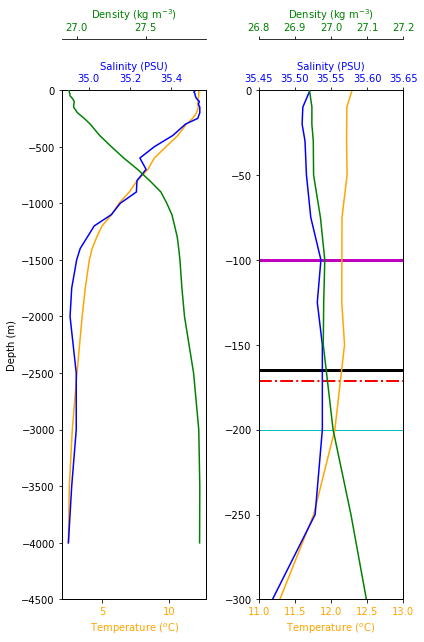

In [94]:
# Time step we work on:: 12, 25, 38, 51
p_gl = Point(nr, 'noe')
place = north
t = 51
print(t)

# Convert(data_set, t) -> (dep, sal, tem, den, temp_pot)
dep, sal, tem, den, pre = Convert(p_gl, t)

## Calculating the deltas
dn02_gl, Ddv_gl = Densities_delta(den, tem, sal, pre, t)
Ddf_gl = 0.03

MLD_a = p_gl.mlotst[t].values
MLD_f, jf = ML_depth(dep, den, Ddf_gl)
MLD_v, jv = ML_depth(dep, den, Ddv_gl)

# Calculating depth from density :: Interpolation
x = den[jv-1:jv+2]
y = dep[jv-1:jv+2]
dep_dens = interpolate.interp1d(x, y, kind='linear')


MLD_int = dep_dens(dn02_gl)
print("MDL by ARMOR: % 5.2f" %(MLD_a))
print("MDL fixed: % 5.2f" %(MLD_f))
print("MDL by variable: % 5.2f" %(MLD_v))
print("MDL by variable+interpolation: % 5.2f" %(MLD_int))

## Making plot
name_fig = dir_2 + 'North-'+ str(t)+'.png'
Plot_density(dep, p_gl.to[t], p_gl.so[t], den, place, t, name_fig)


## Labrador-Irminger Seas

12
MDL by ARMOR:  94.60
MDL fixed: -200.00
MDL by variable: -100.00
MDL by variable+interpolation: -120.72


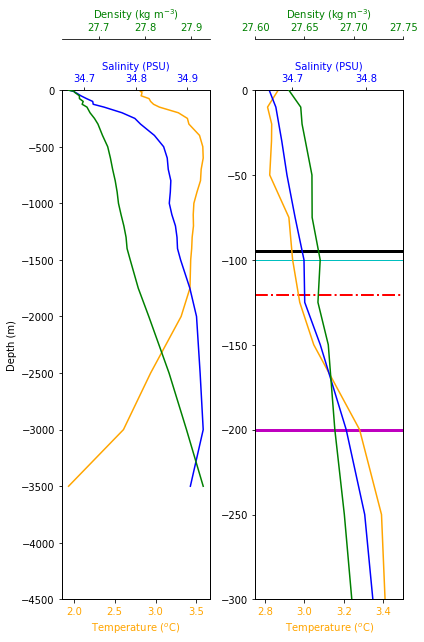

In [95]:
# Time step we work on:: 12, 25, 38, 51
p_gl = Point(lb, 'lab')
place = labrador
t = 12
print(t)

# Convert(data_set, t) -> (dep, sal, tem, den, temp_pot)
dep, sal, tem, den, pre = Convert(p_gl, t)

## Calculating the deltas
dn02_gl, Ddv_gl = Densities_delta(den, tem, sal, pre, t)
Ddf_gl = 0.03

MLD_a = p_gl.mlotst[t].values
MLD_f, jf = ML_depth(dep, den, Ddf_gl)
MLD_v, jv = ML_depth(dep, den, Ddv_gl)

# Calculating depth from density :: Interpolation
x = den[jv-1:jv+2]
y = dep[jv-1:jv+2]
dep_dens = interpolate.interp1d(x, y, kind='linear')


MLD_int = dep_dens(dn02_gl)
print("MDL by ARMOR: % 5.2f" %(MLD_a))
print("MDL fixed: % 5.2f" %(MLD_f))
print("MDL by variable: % 5.2f" %(MLD_v))
print("MDL by variable+interpolation: % 5.2f" %(MLD_int))

## Making plot
name_fig = dir_2 + 'Labrador-'+ str(t)+'.png'
Plot_density(dep, p_gl.to[t], p_gl.so[t], den, place, t, name_fig)


25
MDL by ARMOR:  28.40
MDL fixed: -30.00
MDL by variable: -30.00
MDL by variable+interpolation: -28.47


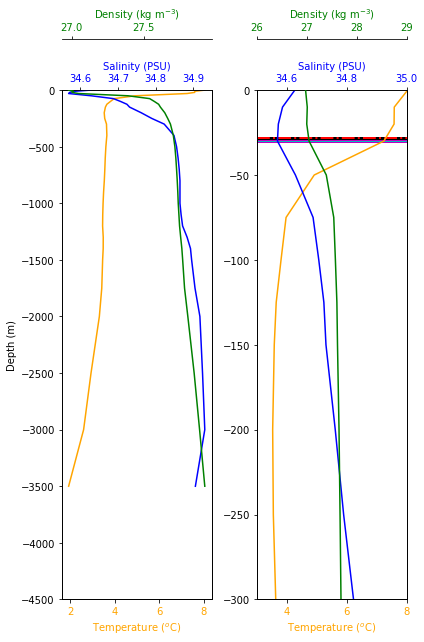

In [96]:
# Time step we work on:: 12, 25, 38, 51
p_gl = Point(lb, 'lab')
place = labrador
t = 25
print(t)

# Convert(data_set, t) -> (dep, sal, tem, den, temp_pot)
dep, sal, tem, den, pre = Convert(p_gl, t)

## Calculating the deltas
dn02_gl, Ddv_gl = Densities_delta(den, tem, sal, pre, t)
Ddf_gl = 0.03

MLD_a = p_gl.mlotst[t].values
MLD_f, jf = ML_depth(dep, den, Ddf_gl)
MLD_v, jv = ML_depth(dep, den, Ddv_gl)

# Calculating depth from density :: Interpolation
x = den[jv-1:jv+2]
y = dep[jv-1:jv+2]
dep_dens = interpolate.interp1d(x, y, kind='linear')


MLD_int = dep_dens(dn02_gl)
print("MDL by ARMOR: % 5.2f" %(MLD_a))
print("MDL fixed: % 5.2f" %(MLD_f))
print("MDL by variable: % 5.2f" %(MLD_v))
print("MDL by variable+interpolation: % 5.2f" %(MLD_int))

## Making plot
name_fig = dir_2 + 'Labrador-'+ str(t)+'.png'
Plot_density(dep, p_gl.to[t], p_gl.so[t], den, place, t, name_fig)


38
MDL by ARMOR:  30.90
MDL fixed: -50.00
MDL by variable: -50.00
MDL by variable+interpolation: -30.88


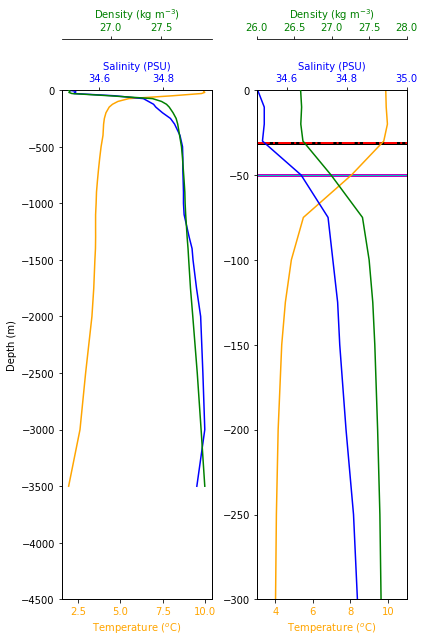

In [97]:
# Time step we work on:: 12, 25, 38, 51
p_gl = Point(lb, 'lab')
place = labrador
t = 38
print(t)

# Convert(data_set, t) -> (dep, sal, tem, den, temp_pot)
dep, sal, tem, den, pre = Convert(p_gl, t)

## Calculating the deltas
dn02_gl, Ddv_gl = Densities_delta(den, tem, sal, pre, t)
Ddf_gl = 0.03

MLD_a = p_gl.mlotst[t].values
MLD_f, jf = ML_depth(dep, den, Ddf_gl)
MLD_v, jv = ML_depth(dep, den, Ddv_gl)

# Calculating depth from density :: Interpolation
x = den[jv-1:jv+2]
y = dep[jv-1:jv+2]
dep_dens = interpolate.interp1d(x, y, kind='linear')


MLD_int = dep_dens(dn02_gl)
print("MDL by ARMOR: % 5.2f" %(MLD_a))
print("MDL fixed: % 5.2f" %(MLD_f))
print("MDL by variable: % 5.2f" %(MLD_v))
print("MDL by variable+interpolation: % 5.2f" %(MLD_int))

## Making plot
name_fig = dir_2 + 'Labrador-'+ str(t)+'.png'
Plot_density(dep, p_gl.to[t], p_gl.so[t], den, place, t, name_fig)

51
MDL by ARMOR:  35.40
MDL fixed: -50.00
MDL by variable: -50.00
MDL by variable+interpolation: -35.40


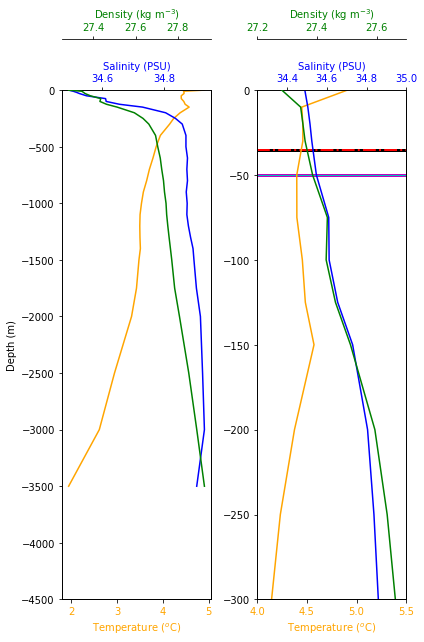

In [98]:
# Time step we work on:: 12, 25, 38, 51
p_gl = Point(lb, 'lab')
place = labrador
t = 51
print(t)

# Convert(data_set, t) -> (dep, sal, tem, den, temp_pot)
dep, sal, tem, den, pre = Convert(p_gl, t)

## Calculating the deltas
dn02_gl, Ddv_gl = Densities_delta(den, tem, sal, pre, t)
Ddf_gl = 0.03

MLD_a = p_gl.mlotst[t].values
MLD_f, jf = ML_depth(dep, den, Ddf_gl)
MLD_v, jv = ML_depth(dep, den, Ddv_gl)

# Calculating depth from density :: Interpolation
x = den[jv-1:jv+2]
y = dep[jv-1:jv+2]
dep_dens = interpolate.interp1d(x, y, kind='linear')


MLD_int = dep_dens(dn02_gl)
print("MDL by ARMOR: % 5.2f" %(MLD_a))
print("MDL fixed: % 5.2f" %(MLD_f))
print("MDL by variable: % 5.2f" %(MLD_v))
print("MDL by variable+interpolation: % 5.2f" %(MLD_int))

## Making plot
name_fig = dir_2 + 'Labrador-'+ str(t)+'.png'
Plot_density(dep, p_gl.to[t], p_gl.so[t], den, place, t, name_fig)
